## Presence-absence field validation

This notebook creates synthetic data for 3 example presence-absence fields then compares the true field to the inferred field.

In [1]:
import os, sys
from getpass import getpass
import numpy as np
from math import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
#!pip install -qq gstools
!pip install meshio==5.0.5 gstools
import gstools as gs
from scipy import interpolate




datadir = './'

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tfb = tfp.bijectors

import gpflow as gpf

print(tfp.__version__)
print(tf.__version__)
plt.style.use('seaborn-whitegrid')
#plt.style.available

0.14.1
2.6.2


In [3]:
vals = [2,4,6]

for v in vals:
    p = 0.1*v
    print('creating data for presence fraction', str(p))

    # make a random field with 2k correlation length
    x = y = np.arange(0,50000,100)
    L = 2000
    var=1.0
    model = gs.Exponential(dim=2, var=var, len_scale=L)

    srf = gs.SRF(model)

    field = srf.structured([x, y])

    # make a 5k presence-absence field
    L = 4000
    var = 1

    model = gs.Gaussian(dim=2, var=var, len_scale=L)
    srf = gs.SRF(model)

    # we make the pa field bigger so we can centre it on the largest cluster of wildebeest
    x2 = y2 = np.arange(-50000,100000,1000)
    pa_field = srf.structured([x2, y2])
    # interpolate as the grid generation is slow for large N
    f = interpolate.interp2d(x2, y2, pa_field, kind='cubic')
    x2 = y2 = np.arange(-50000,100000,100)

    pa_field = f(x2,y2)

    # next we find the highest value of the pa field
    ij = pa_field[500:1000,500:1000].argmax()
    # and centre it so it's at the middle of the survey
    i = ij//500
    j = ij - i*500
    pa_field2 = pa_field[500+i-250:500+i+250,500+j-250:500+j+250]
    # only populate the top p%
    cutoff = np.percentile(pa_field2,100*(1-p))

    # set to negative infinity sets it to zero when we take the exponential
    field[pa_field2<cutoff]=-np.inf

    #set the mean so we end up with roughly 1.3m wildebeest
    target_w = 1300000
    vf = np.var(field[np.isfinite(field)])
    mf = np.mean(field[np.isfinite(field)])
    target_log_density = np.log(target_w/(p*50000*50000))-0.5*vf-mf

    # generate a random count for each grid cell of 100mx100m
    wcounts = np.random.poisson(lam = 100*100*np.exp(target_log_density+field))

    # next place the wildebeest in a random location within their cell
    total = wcounts.sum()
    positions = np.zeros((total,2))

    min_x = 0
    max_x = 50000
    min_y = 0
    max_y = 50000
    #print(total)
    w = 0
    for i in (range(len(x))):
        for j in range(len(y)):
            wtotal =  wcounts[i,j]
            positions[w:w+wtotal,0]=x[i]+np.random.uniform(100,size=wtotal) # place at random in the 100x100 cell
            positions[w:w+wtotal,1]=y[j]+np.random.uniform(100,size=wtotal)
            w = w + wtotal

    presence_field = np.ones_like(pa_field2)
    presence_field[pa_field2<cutoff]=0
    
    outputfile = '../data/simdata/field_example_p' + str(v) + '.npy'
    # save the field for plotting
    np.save(outputfile,presence_field)
    
    
    # fly the survey
    yvals = np.arange(positions[:,1].min(),positions[:,1].max(),2500)
    yvals = np.arange(135,max_y,2500)
    photos=[]
    transect=0
    for yv in (yvals):

        ymin = yv - 135
        ymax = yv + 135
        
        xvals = np.arange(90,max_x,500)

        if len(xvals):
            transect+=1

        for xv in xvals:

            xmin = xv - 90
            xmax = xv + 90
            
            count = np.sum((positions[:,0]>xmin)&(positions[:,0]<xmax)&(positions[:,1]>ymin)&(positions[:,1]<ymax))

            photo = [xv,yv,count,transect]
            photos.append(photo)

    photos = np.array(photos)    

    
    # save the data
    outputfile = '../data/simdata/field_example_p' + str(v) + '.csv'

    f = open(outputfile,'w')
    f.write("x,y,wildebeest,transect_id,photo_area\n")

    x_str = '%.2f,' % 0
    y_str = '%.2f,' % 0
    w_str = '%d,' % total
    t_str = '%d,' % -1
    a_str = '%d' % 0
    f.write(x_str + y_str + w_str + t_str + a_str )
    f.write('\n')
    for photo in photos:
        x_str = '%.2f,' % (photo[0]/1)
        y_str = '%.2f,' % (photo[1]/1)
        w_str = '%d,' % photo[2]
        t_str = '%d,' % photo[3]
        a_str = '%.6f' % (180*270/1/1)
        f.write(x_str + y_str + w_str + t_str + a_str )
        f.write('\n')
    f.close()


creating data for presence fraction 0.2
creating data for presence fraction 0.4
creating data for presence fraction 0.6000000000000001


## Inference

Next we infer the fields using the multilatent method

In [4]:
import os, sys
from getpass import getpass
import numpy as np
from math import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tfb = tfp.bijectors

import gpflow as gpf

from gpflow.config import default_float

class ZipLikelihood(gpf.likelihoods.MultiLatentTFPConditional):
    """
    Zero-inflated Poisson Likelihood where the conditional distribution
    is given by a TensorFlow Probability Distribution.
    The `presence` and `rate` of the distribution are given by a
    two-dimensional multi-output GP.
    """

    def __init__(
        self,
         binsize=1.0,
        **kwargs,
    ):
        """
        :param binsize: array of areas for Poisson distribution
        """
        self.binsize = np.reshape(np.array(binsize, dtype=default_float()),(-1,1))

        def conditional_distribution(Fs) -> tfp.distributions.Distribution:
            tf.debugging.assert_equal(tf.shape(Fs)[-1], 2)
            f = (Fs[..., :1])
            g = (Fs[..., 1:])
            
            g = tf.math.sigmoid(g)
            h = tf.stack((1-g,g),axis=-1)
            
            return tfd.Mixture(cat=tfd.Categorical(probs=(h)),
                                      components=[tfd.Deterministic(loc=tf.zeros_like((f))),
                                      tfd.Poisson(log_rate= (f + tf.math.log(self.binsize)))])


        super().__init__(
            latent_dim=2, conditional_distribution=conditional_distribution, **kwargs,
        )


max_train=100


In [5]:

vals = [2,4,6]




for v in vals:



    inputfile = '../data/simdata/field_example_p' + str(v) + '.csv'


    df =pd.read_csv(inputfile)
    trueW = df[df.transect_id<0].wildebeest.values[0]
    df = df[df.transect_id>0]

    num_photo = len(df)

    X = df[['x','y']].values/1000
    wdata = df['wildebeest'].values[:,None].astype(np.float64)

    areas = df.photo_area.values/1000/1000


    data = (X, wdata)


    # average intensity of images with wildebeest present
    mean_log_intensity = np.log(wdata[wdata>0].sum()/areas[wdata[:,0]>0].sum())

    # average probability of wildebeest present
    p = wdata[wdata>0].shape[0]/wdata.shape[0]
    p = min(0.99,p)
    mean_presence = np.log(p/(1.000-p))

    v1=5.
    v2=5.
    l1=1.
    l2=1.

    num_latent_gps=2

    inducing_variable = gpf.inducing_variables.SeparateIndependentInducingVariables(
        [
            gpf.inducing_variables.InducingPoints(X),  # This is U1 = f1(Z1)
            gpf.inducing_variables.InducingPoints(X),  # This is U2 = f2(Z2)
        ]
    )

    likelihood = ZipLikelihood(binsize=areas)

    kernel = gpf.kernels.SeparateIndependent(
        [
            gpf.kernels.Matern32(variance=v1,lengthscales=l1),  # This is k1, the kernel of f
            gpf.kernels.Matern32(variance=v2,lengthscales=l2),  # this is k2, the kernel of g

        ]
    )
    means = np.array([mean_log_intensity,mean_presence]).reshape((-1,1))
    mean_fn = gpf.mean_functions.Constant(c=means)


    svgp = gpf.models.SVGP(inducing_variable=inducing_variable,
                            kernel=kernel,
                            mean_function=mean_fn,
                            num_latent_gps=num_latent_gps,
                            likelihood = likelihood, q_diag=False  )
    gpf.set_trainable(svgp.inducing_variable.inducing_variable_list[0].Z,False)
    gpf.set_trainable(svgp.inducing_variable.inducing_variable_list[1].Z,False)

    f64 = np.float64
    svgp.kernel.kernels[0].lengthscales.prior = tfd.Gamma(f64(2.0), f64(0.5))
    svgp.kernel.kernels[0].variance.prior = tfd.Gamma(f64(2.0), f64(2.0))

    svgp.kernel.kernels[1].lengthscales.prior = tfd.Gamma(f64(2.0), f64(0.5))
    svgp.kernel.kernels[1].variance.prior = tfd.Gamma(f64(2.0), f64(2.0))


    opt = gpf.optimizers.Scipy()
    training_loss = svgp.training_loss_closure(data, compile=True)
    opt.minimize(training_loss, variables=svgp.trainable_variables,options=dict(maxiter=1000) )


    ngrid=50
    pred_locations = np.array([np.linspace(0.5,49.5,ngrid),np.linspace(0.5,49.5,ngrid)])


    xx, yy = np.meshgrid(pred_locations[0], pred_locations[1], sparse=False)
    x_grid = np.array([xx.flatten(), yy.flatten()]).T

    # save the presence absence only
    y_pred = tf.nn.sigmoid(svgp.predict_f(x_grid)[0][:,1]).numpy().reshape(50,50)
    outputfile = '../data/simdata/field_inferred_p' + str(v) + '.npy'
    
    np.save(outputfile,y_pred)


2022-04-22 09:59:19.054715: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-22 09:59:20.363569: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15391 MB memory:  -> device: 0, name: Quadro GP100, pci bus id: 0000:3b:00.0, compute capability: 6.0
2022-04-22 09:59:21.254894: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid value for "node": expected "ast.AST", got "<class 'NoneType'>"; to visit lists of nodes, use "visit_block" instead
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid value for "node": expected "ast.AST", got "<class 'NoneType'>"; to visit lists of nodes, use "visit_block" instead
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
The `interpolate_nondiscrete` flag is deprecated; instead use `force_probs_to_zero_outside_support` (with the opposite sense).


2022-04-22 09:59:39.124490: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-22 09:59:42.523510: I tensorflow/core/util/cuda_solvers.cc:180] Creating CudaSolver handles for stream 0x55b1b4512ba0


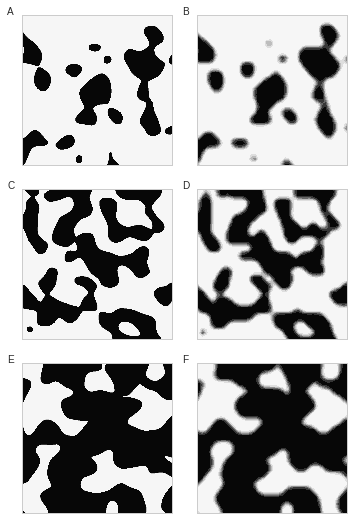

In [7]:


fig, axs = plt.subplots(3, 2, figsize=(4.8,7.2), constrained_layout=True)


for i,v in enumerate(vals):
    pred_file = '../data/simdata/field_inferred_p' + str(v) + '.npy'
    predictField = np.load(pred_file)
    
    truefile = '../data/simdata/field_example_p' + str(v) + '.npy'

    trueField = np.load(truefile)
    


    ax = axs[i, 0].contourf(y,x,trueField.T,vmin=0,vmax=1.0)
    axs[i, 0].set_aspect('equal')

    ax12 = axs[i, 1].contourf(pred_locations[1], pred_locations[0],predictField,vmin=0,vmax=1.0)
    axs[i, 1].set_aspect('equal')

    

axs[0,0].text(-0.1,1,'A', size=10, transform=axs[0, 0].transAxes)
axs[0,1].text(-0.1,1,'B', size=10, transform=axs[0, 1].transAxes)
axs[1,0].text(-0.1,1,'C', size=10, transform=axs[1, 0].transAxes)
axs[1,1].text(-0.1,1,'D', size=10, transform=axs[1, 1].transAxes)
axs[2,0].text(-0.1,1,'E', size=10, transform=axs[2, 0].transAxes)
axs[2,1].text(-0.1,1,'F', size=10, transform=axs[2, 1].transAxes)


axs[0,0].tick_params( labelleft=False, labelbottom=False) 
axs[0,1].tick_params( labelleft=False, labelbottom=False) 
axs[1,0].tick_params( labelleft=False, labelbottom=False) 
axs[1,1].tick_params( labelleft=False, labelbottom=False) 
axs[2,0].tick_params( labelleft=False, labelbottom=False) 
axs[2,1].tick_params( labelleft=False, labelbottom=False) 
plt.savefig("comparison_true_inferred_pa.pdf",bbox_inches='tight')

plt.show()